In [5]:
import pickle
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from project_helper import FuturesCloseData, VolFeatures, TradeModel
import matplotlib.pyplot as plt
#import graphviz

In [6]:
svd_df_daily = pd.read_csv('combined_svd_df.csv',names=['index','svd_1','svd_2','date'], index_col = 0, skiprows = 1)
svd_df_daily.set_index('date', inplace = True)
svd_df_daily.index = pd.to_datetime(svd_df_daily.index) + timedelta(days=-1)
svd_df_daily.head()

,svd_1,svd_2
date,,
2009-05-04,0.231291,0.194568
2009-05-07,0.052782,0.062221
2009-05-08,0.079785,0.035236
2009-05-11,0.098248,0.041978
2009-05-12,0.069910,0.062147


In [67]:
intraday = pd.read_csv('intraday.csv', names= ['date','ret'])
intraday.set_index('date', inplace = True)
#intraday = 2 * (intraday > 0 ) -1  
#intraday.head()

In [32]:
fc = FuturesCloseData()
fc.returns('ES').head()

date
2014-01-02   -0.002707
2014-01-03    0.005713
2014-01-06    0.000994
2014-01-07    0.000284
2014-01-08    0.002695
Name: ES, dtype: float64

In [33]:
vol = VolFeatures()
vol.features('ES').head()

,ES_1M_atm_vol,ES_1M_RR25,ES_1M_RR10,ES_1M_Fly25,ES_1M_Fly10,ES_2M_atm_vol,ES_2M_RR25,ES_2M_RR10,ES_2M_Fly25,ES_2M_Fly10,ES_2M_1M_atm_vol
Date,,,,,,,,,,,
2016-11-14,0.119889,-0.037174,-0.073479,0.003789,0.015547,0.125210,-0.046645,-0.088709,0.004540,0.017257,0.005205
2016-11-15,0.097407,-0.019810,-0.038827,0.004464,0.018210,0.116007,-0.037339,-0.070383,0.004491,0.016703,0.018506
2016-11-16,0.086325,-0.015557,-0.032338,0.003478,0.014565,0.118026,-0.039720,-0.075981,0.004275,0.016356,0.031726
2016-11-17,0.078008,-0.013282,-0.026062,0.003378,0.013855,0.114574,-0.037722,-0.072023,0.003713,0.014712,0.036573
2016-11-18,0.062015,-0.009879,-0.019785,0.002611,0.011093,0.110443,-0.037831,-0.073675,0.002989,0.013092,0.048422


In [68]:
instrument_list = ['ES', 'NQ', 'CD', 'EC', 'JY', 'MP', 'TY', 'US', 'C', 'S', 'W', 'CL', 'GC']
X_dict = {}
y_dict = {}
date_min = pd.to_datetime('2016-11-14')
date_max = pd.to_datetime('2019-09-25')
for inst in instrument_list:
    X = intraday.join(svd_df_daily).join(fc.features(inst)).join(vol.features(inst)).dropna()
    X = X[(X.index >= date_min) & (X.index <= date_max)]
    X_dict[inst] = X
    y_dict[inst] = fc.returns(inst)[X.index]


X_dict

In [84]:
instrument_list = ['ES', 'NQ', 'CD', 'EC', 'JY', 'MP', 'C', 'S', 'W', 'CL']
strat_sharpes = {}
strat_rets = {}
strat_cum_rets = {}
strat_models = {}
for inst in instrument_list:
    y = 2 * (y_dict[inst]>= 0) - 1
    X_train, X_test, y_train, y_test = train_test_split(X_dict[inst], y, test_size=0.50, shuffle=False )
    tm = TradeModel(n_estimators=1000, max_features=10, max_depth=15, criterion ='entropy')
    tm.fit(X_train, y_train)
    strat_models[inst] = tm
    strat_rets[inst], strat_cum_rets[inst] = tm.strategy_returns(X_test, y_dict[inst][-len(X_test):], cutoff=0.55)
    strat_sharpes[inst] = tm.sharpe(X_test, y_dict[inst][-len(X_test):],cutoff=0.55)
    print('{} sharpe {}:'.format(inst, strat_sharpes[inst]))
    

ES sharpe 0.06151205127134398:
NQ sharpe -0.06112494062144267:
CD sharpe 0.04921258107957357:
EC sharpe 0.051185964946087334:
JY sharpe 0.06860385077907538:
MP sharpe -0.034072174036506676:
C sharpe 0.0489831154810019:
S sharpe -0.005996430130781071:
W sharpe 0.01638130300752845:
CL sharpe 0.013659688666604114:


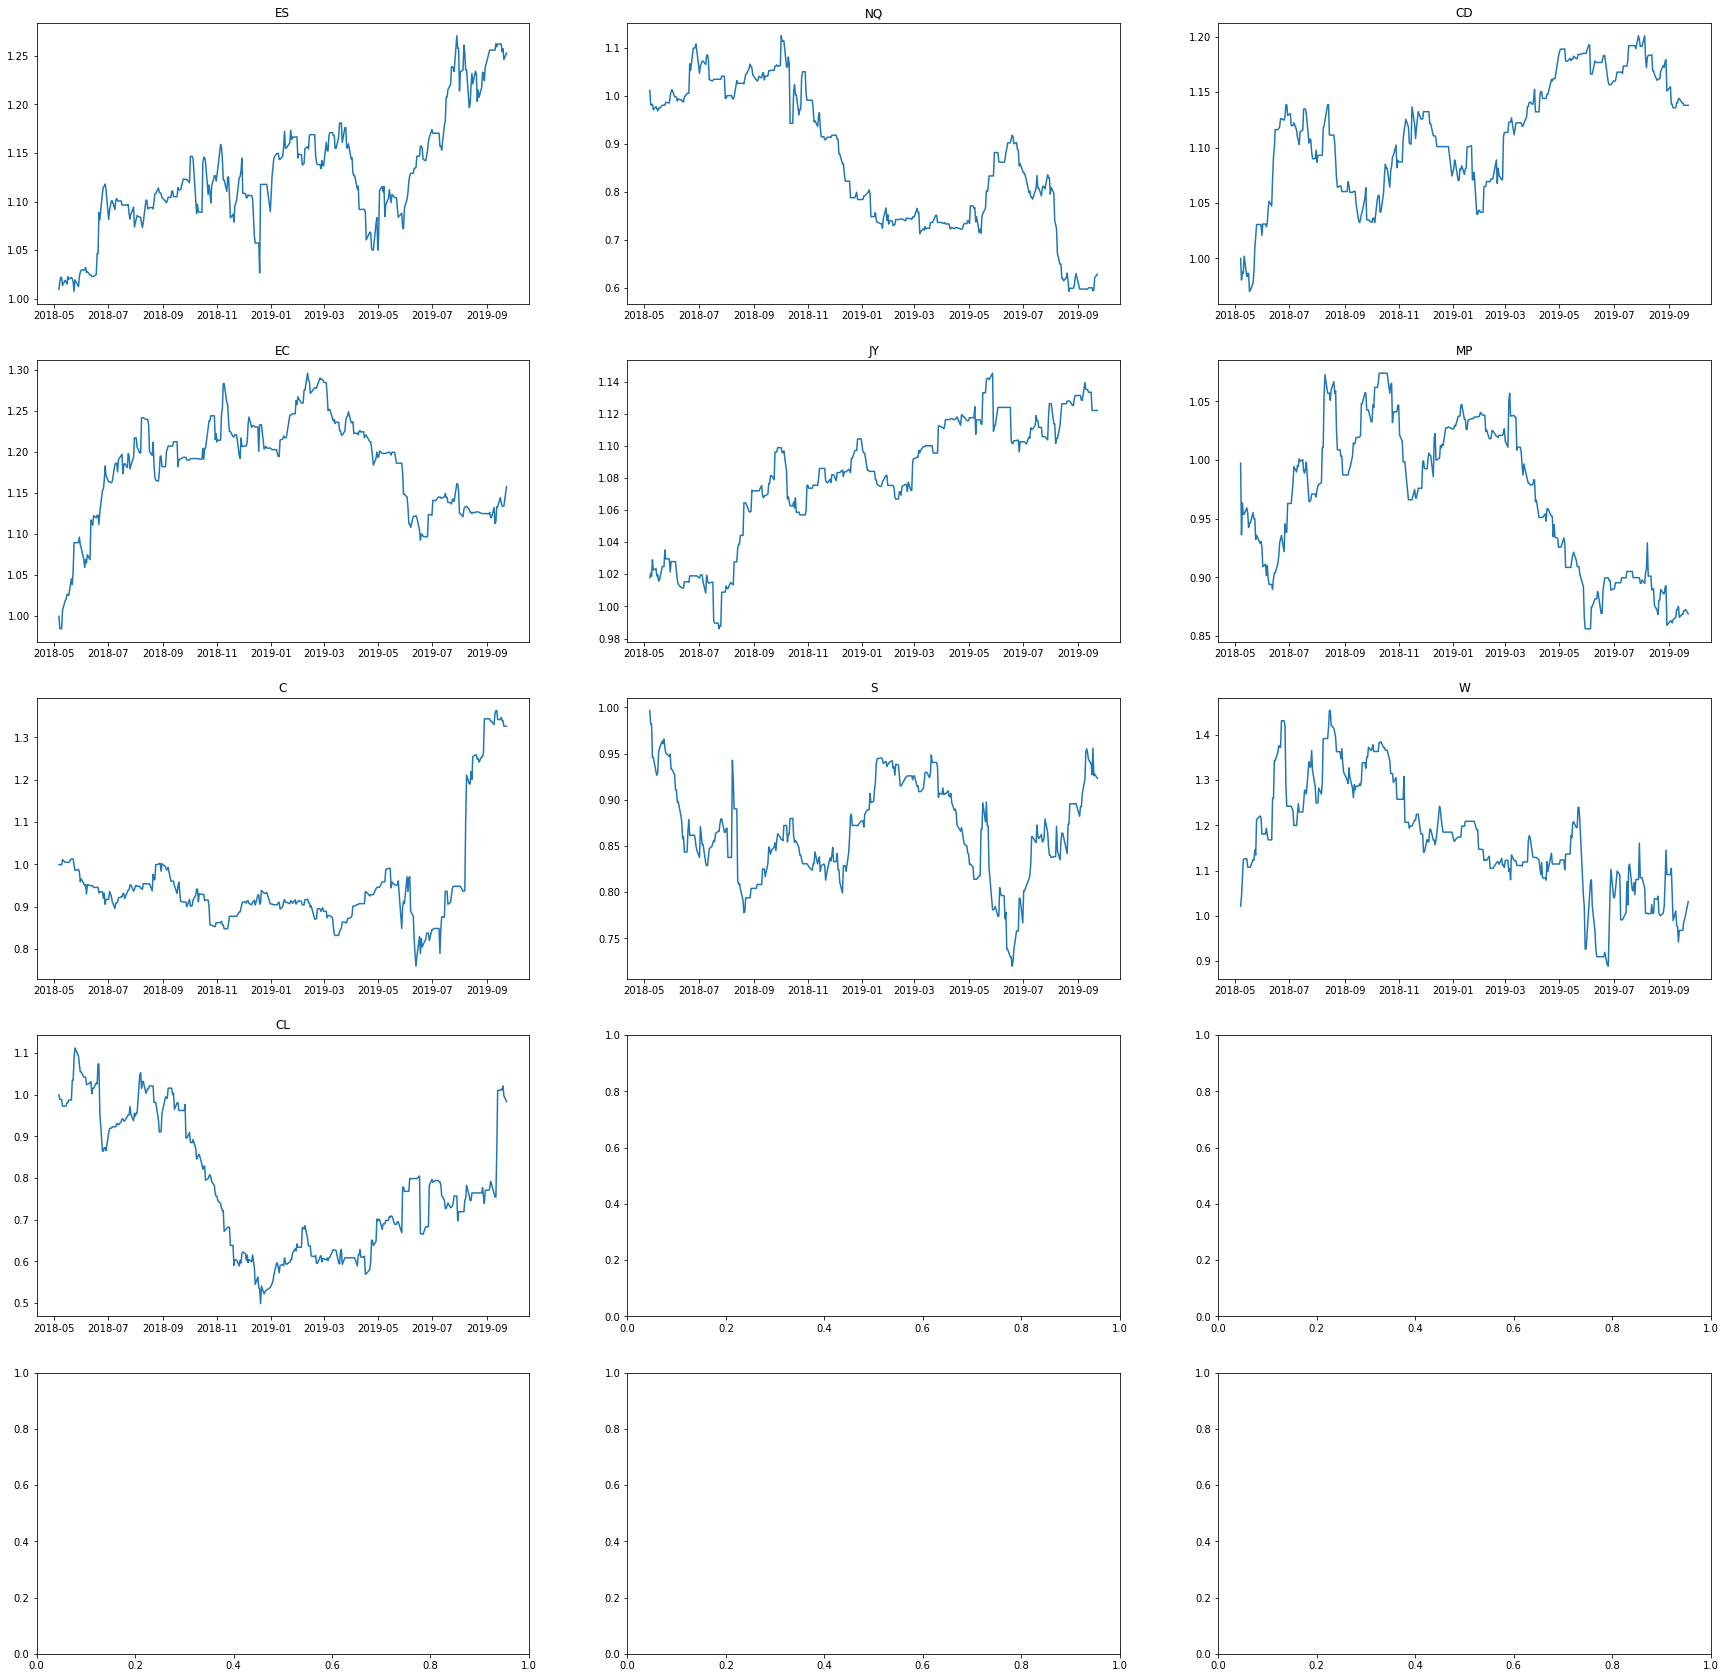

In [85]:
fig, ax = plt.subplots(5,3,figsize=(30,30))
ax = ax.ravel()
for i, inst in enumerate(instrument_list):
    ax[i].plot(strat_cum_rets[inst])
    ax[i].set_title(inst)


0.036888219523362076


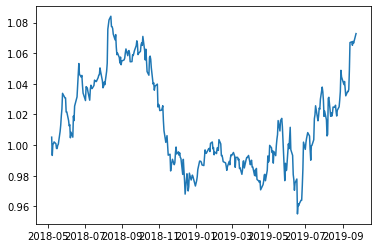

In [87]:
port_rets = pd.DataFrame(strat_rets).mean(axis=1)
plt.plot((1 + pd.DataFrame(strat_rets).mean(axis=1)).cumprod())
print(port_rets.mean()/port_rets.std())

In [88]:
strat_models['NQ'].model.feature_importances_

array([0.10295298, 0.08211065, 0.09327621, 0.07483265, 0.06239208,
       0.05045619, 0.06998701, 0.05711401, 0.06087785, 0.05828565,
       0.05081987, 0.04816271, 0.065587  , 0.05983716, 0.06330797])

In [79]:
strat_sharpes

{'ES': 0.04761401289908193,
 'NQ': -0.06264879548554249,
 'CD': 0.05326904752211021,
 'EC': 0.014755194653581253,
 'JY': 0.03762405628052441,
 'TY': -0.09502925324486547,
 'US': -0.06485428191796053,
 'MP': 0.012934413090883003,
 'C': 0.04169068647997953,
 'S': -0.030241991028819467,
 'W': 0.03175795820997718,
 'CL': 0.005098709049618091,
 'GC': -0.05278854378750383}

In [44]:
tm.strategy_returns(X_test, y_dict['ES'][-len(X_test):])[1]

date
2018-04-26    1.000000
2018-04-27    1.000000
2018-04-30    1.027747
2018-05-01    1.027747
2018-05-02    1.027747
                ...   
2019-09-17    1.149651
2019-09-18    1.170863
2019-09-19    1.170863
2019-09-20    1.160413
2019-09-23    1.166664
Name: ES, Length: 355, dtype: float64

In [45]:
tm.sharpe(X_test, y_dict['ES'][-len(X_test):])

0.04252378742988993

In [46]:
tm.model.feature_importances_

array([0.09580741, 0.11283748, 0.0951219 , 0.07751538, 0.05740201,
       0.05044748, 0.05587859, 0.06217403, 0.07755241, 0.05777897,
       0.0477254 , 0.06483487, 0.07189334, 0.07303073])

In [ ]:
'''
dot_data = export_graphviz(tree, out_file=None, 
                      feature_names=X_train.columns,  
                     class_names=[str(1),str(-1)],  
                     filled=True, rounded=True,  
                    special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 
'''